In [1]:
# Q4 2025 Spending Prediction – Full Feature Engineering Pipeline

import pandas as pd
import numpy as np
# Filter transaction data


account = pd.read_csv("account_dim_20250325.csv")
statement = pd.read_csv("statement_fact_20250325.csv")
transaction = pd.read_csv("transaction_fact_20250325.csv")

# --------------------------------------------
# STEP 1: Preprocess transaction data
# --------------------------------------------
transaction["transaction_date"] = pd.to_datetime(transaction["transaction_date"])
transaction["year"] = transaction["transaction_date"].dt.year
transaction["month"] = transaction["transaction_date"].dt.month
start_date = pd.to_datetime("2024-03-01")
end_date = pd.to_datetime("2025-03-31")
transaction = transaction[(transaction["transaction_date"] >= start_date) & (transaction["transaction_date"] <= end_date)]

monthly_spending = (
    transaction.groupby(["current_account_nbr", "year", "month"])["transaction_amt"]
    .sum()
    .reset_index()
    .rename(columns={"transaction_amt": "monthly_spending"})
)

monthly_pivot = monthly_spending.pivot_table(
    index="current_account_nbr",
    columns=["year", "month"],
    values="monthly_spending",
    fill_value=0
)
monthly_pivot.columns = [f"{y}_{m:02d}" for y, m in monthly_pivot.columns]
monthly_pivot = monthly_pivot.reindex(sorted(monthly_pivot.columns), axis=1)

# --------------------------------------------
# STEP 2: Rolling window features (last 8 months from latest)
# --------------------------------------------
latest_year = transaction["year"].max()
latest_month = transaction[transaction["year"] == latest_year]["month"].max()
months_back = [(latest_year if latest_month - i > 0 else latest_year - 1,
                latest_month - i if latest_month - i > 0 else 12 + (latest_month - i))
               for i in range(8)]
available_months = [f"{y}_{m:02d}" for y, m in months_back if f"{y}_{m:02d}" in monthly_pivot.columns]

monthly_pivot["avg_spend_8mo"] = monthly_pivot[available_months].mean(axis=1)
monthly_pivot["std_spend_8mo"] = monthly_pivot[available_months].std(axis=1)
monthly_pivot["max_spend_8mo"] = monthly_pivot[available_months].max(axis=1)
monthly_pivot["min_spend_8mo"] = monthly_pivot[available_months].min(axis=1)
monthly_pivot["mo_growth_rate"] = (
    monthly_pivot[available_months].pct_change(axis=1).mean(axis=1)
    if len(available_months) >= 2 else np.nan
)

# --------------------------------------------
# STEP 3: Historical Q4 spending
# --------------------------------------------
for year in [2023, 2024]:
    q4 = [f"{year}_{m:02d}" for m in [10, 11, 12] if f"{year}_{m:02d}" in monthly_pivot.columns]
    monthly_pivot[f"{year}_Q4_total"] = monthly_pivot[q4].sum(axis=1)
    monthly_pivot[f"{year}_Q4_avg"] = monthly_pivot[q4].mean(axis=1)

# --------------------------------------------
# STEP 4: Account-level features
# --------------------------------------------
account["open_date"] = pd.to_datetime(account["open_date"], utc=True).dt.tz_localize(None)
account["account_age_months"] = (pd.Timestamp("2025-03-31") - account["open_date"]).dt.days // 30
account_sub = account[[
    "current_account_nbr", "account_age_months", "account_card_type", "overlimit_type_flag"
]]

# --------------------------------------------
# STEP 5: Statement-level features (latest only)
# --------------------------------------------
statement["billing_cycle_date"] = pd.to_datetime(statement["billing_cycle_date"])
latest_statements = statement.sort_values("billing_cycle_date") \
    .groupby("current_account_nbr").last().reset_index()

statement_sub = latest_statements[[
    "current_account_nbr", "prev_balance", "return_check_cnt_ytd"
]]

# --------------------------------------------
# STEP 6: Final merge
# --------------------------------------------
final_data = monthly_pivot.merge(account_sub, how="left", on="current_account_nbr")
final_data = final_data.merge(statement_sub, how="left", on="current_account_nbr")

final_data.reset_index(inplace=True)
# Display the final dataframe
print("\nFinal Feature Dataset:")
print("-" * 80)
print(f"Shape: {final_data.shape}")
print("\nColumns:")
for col in final_data.columns:
    print(f"- {col}")
print("\nFirst few rows:")
display(final_data.head())




/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)



Final Feature Dataset:
--------------------------------------------------------------------------------
Shape: (14099, 29)

Columns:
- index
- current_account_nbr
- 2024_03
- 2024_04
- 2024_05
- 2024_06
- 2024_07
- 2024_08
- 2024_09
- 2024_10
- 2024_11
- 2024_12
- 2025_01
- 2025_02
- 2025_03
- avg_spend_8mo
- std_spend_8mo
- max_spend_8mo
- min_spend_8mo
- mo_growth_rate
- 2023_Q4_total
- 2023_Q4_avg
- 2024_Q4_total
- 2024_Q4_avg
- account_age_months
- account_card_type
- overlimit_type_flag
- prev_balance
- return_check_cnt_ytd

First few rows:


,index,current_account_nbr,2024_03,2024_04,2024_05,2024_06,2024_07,2024_08,2024_09,2024_10,...,mo_growth_rate,2023_Q4_total,2023_Q4_avg,2024_Q4_total,2024_Q4_avg,account_age_months,account_card_type,overlimit_type_flag,prev_balance,return_check_cnt_ytd
0,0,00gwujJkd597VxLd,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,-1.000000,0.0,NaN,0.00,0.000000,0,DUAL CARD,0,NaN,NaN
1,1,00iP5U82D8XwVQ9G,93.23,758.42,381.44,191.73,892.79,647.15,722.78,1017.18,...,0.006942,0.0,NaN,3449.74,1149.913333,68,PLCC,0,474.19,0.0
2,2,00oyr3QppAzjLws4,0.00,268.85,191.08,165.59,230.04,80.00,80.00,85.00,...,0.114984,0.0,NaN,515.96,171.986667,98,PLCC,0,2635.01,0.0
3,3,02WRVV8yusgcZWLW,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,-0.499320,0.0,NaN,0.00,0.000000,128,DUAL CARD,0,1513.08,0.0
4,4,033o9yHYen3xoz6k,1252.33,1685.22,1653.14,1572.67,1417.73,1848.35,2120.79,258.32,...,2.663820,0.0,NaN,8042.30,2680.766667,104,DUAL CARD,0,1382.67,0.0


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lightgbm import LGBMRegressor

# Load data
df = pd.read_csv("q4_spending_feature_set.csv")

# Drop fully missing or problematic columns
df = df.drop(columns=["2023_Q4_avg", "account_card_type"], errors='ignore')

# Fill missing values
df["mo_growth_rate"].fillna(df["mo_growth_rate"].median(), inplace=True)
df["prev_balance"].fillna(df["prev_balance"].median(), inplace=True)
df["return_check_cnt_ytd"].fillna(df["return_check_cnt_ytd"].median(), inplace=True)

# Set target and features
target = "2024_Q4_total"
exclude = ["index", "current_account_nbr", target, "2023_Q4_total", "2024_Q4_avg"]
features = [col for col in df.columns if col not in exclude + ["2024_10", "2024_11", "2024_12"]]

X = df[features]
y = df[target]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train LightGBM
lgb_model = LGBMRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
lgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = lgb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"✅ MAE: {mae:.2f}")
print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ R²: {r2:.4f}")


/var/folders/92/8b71n6kj0h33ch61yv1mfqxw0000gn/T/ipykernel_85986/1628936251.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["mo_growth_rate"].fillna(df["mo_growth_rate"].median(), inplace=True)
/var/folders/92/8b71n6kj0h33ch61yv1mfqxw0000gn/T/ipykernel_85986/1628936251.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4339
[LightGBM] [Info] Number of data points in the train set: 11279, number of used features: 18
[LightGBM] [Info] Start training from score 2457.811409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


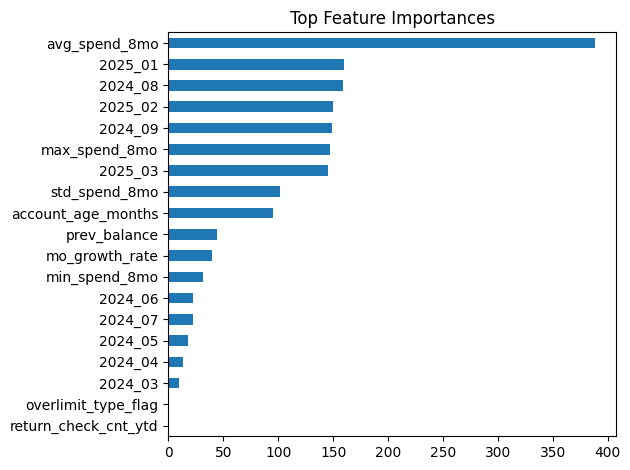

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

importance = pd.Series(lgb_model.feature_importances_, index=X.columns)
importance.sort_values(ascending=False).head(20).plot(kind='barh')
plt.title("Top Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [10]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load data
df = pd.read_csv("q4_spending_feature_set.csv")

# Drop unneeded columns
df.drop(columns=["2023_Q4_avg", "account_card_type"], errors='ignore', inplace=True)

# Fill missing values
df["mo_growth_rate"].fillna(df["mo_growth_rate"].median(), inplace=True)
df["prev_balance"].fillna(df["prev_balance"].median(), inplace=True)
df["return_check_cnt_ytd"].fillna(df["return_check_cnt_ytd"].median(), inplace=True)

# Define features
month_features = [f"2024_{m:02d}" for m in range(4, 12)]  # Apr to Nov 2024
engineered_features = [
    "avg_spend_8mo", "std_spend_8mo", "max_spend_8mo", "min_spend_8mo",
    "mo_growth_rate", "account_age_months", "overlimit_type_flag",
    "prev_balance", "return_check_cnt_ytd"
]
X = df[month_features + engineered_features]

# Define target: Dec 2024 to Mar 2025
target_months = ["2024_12", "2025_01", "2025_02", "2025_03"]
y = df[target_months].sum(axis=1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train LightGBM
lgb_model = LGBMRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
lgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = lgb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"✅ MAE: {mae:.2f}")
print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ R²: {r2:.4f}")


/var/folders/92/8b71n6kj0h33ch61yv1mfqxw0000gn/T/ipykernel_85986/2873829185.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["mo_growth_rate"].fillna(df["mo_growth_rate"].median(), inplace=True)
/var/folders/92/8b71n6kj0h33ch61yv1mfqxw0000gn/T/ipykernel_85986/2873829185.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3829
[LightGBM] [Info] Number of data points in the train set: 11279, number of used features: 16
[LightGBM] [Info] Start training from score 3384.891794
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


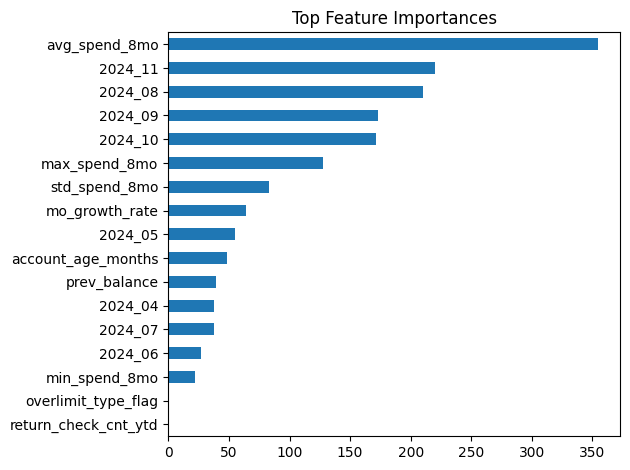

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

importance = pd.Series(lgb_model.feature_importances_, index=X.columns)
importance.sort_values(ascending=False).head(20).plot(kind='barh')
plt.title("Top Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
